# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


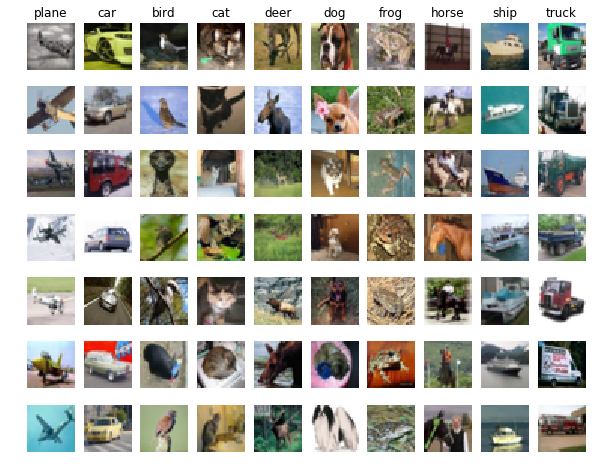

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print 'Training data shape: ', X_train.shape
print 'Validation data shape: ', X_val.shape
print 'Test data shape: ', X_test.shape
print 'dev data shape: ', X_dev.shape

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


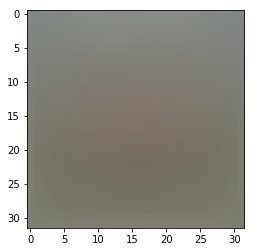

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print mean_image[:10] # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print X_train.shape, X_val.shape, X_test.shape, X_dev.shape

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.00001)
print 'loss: %f' % (loss, )

loss: 9.240366


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [10]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -9.739308 analytic: -9.739308, minus: 0.000000, relative error: 2.332509e-11
numerical: 15.780000 analytic: 15.780000, minus: 0.000000, relative error: 6.287042e-12
numerical: 0.370662 analytic: 0.370662, minus: 0.000000, relative error: 6.299405e-10
numerical: 8.541937 analytic: 8.541937, minus: 0.000000, relative error: 4.221634e-12
numerical: -12.214966 analytic: -12.214966, minus: 0.000000, relative error: 2.322024e-11
numerical: 21.133203 analytic: 21.133203, minus: 0.000000, relative error: 3.289250e-12
numerical: 5.583857 analytic: 5.583857, minus: 0.000000, relative error: 7.463657e-12
numerical: 11.538034 analytic: 11.538034, minus: 0.000000, relative error: 2.568312e-11
numerical: 14.918735 analytic: 14.918735, minus: 0.000000, relative error: 5.116032e-12
numerical: 18.659852 analytic: 18.659852, minus: 0.000000, relative error: 7.072260e-12
numerical: -10.602491 analytic: -10.602491, minus: 0.000000, relative error: 5.619173e-12
numerical: 8.414898 analytic: 8.41

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

In [11]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# The losses should match but your vectorized implementation should be much faster.
print 'difference: %f' % (loss_naive - loss_vectorized)

Naive loss: 9.240366e+00 computed in 0.174556s
Vectorized loss: 9.240366e+00 computed in 0.005186s
difference: 0.000000


In [12]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Naive loss and gradient: computed in %fs' % (toc - tic)

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Vectorized loss and gradient: computed in %fs' % (toc - tic)

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'difference: %f' % difference

Naive loss and gradient: computed in 0.177153s
Vectorized loss and gradient: computed in 0.002043s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [13]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print 'That took %fs' % (toc - tic)

iteration 0 / 1500: loss 24.608935
iteration 100 / 1500: loss 8.458549
iteration 200 / 1500: loss 6.067430
iteration 300 / 1500: loss 5.694357
iteration 400 / 1500: loss 4.726219
iteration 500 / 1500: loss 4.462882
iteration 600 / 1500: loss 4.552559
iteration 700 / 1500: loss 4.847521
iteration 800 / 1500: loss 4.549044
iteration 900 / 1500: loss 5.719518
iteration 1000 / 1500: loss 4.552810
iteration 1100 / 1500: loss 5.047079
iteration 1200 / 1500: loss 4.531060
iteration 1300 / 1500: loss 4.600066
iteration 1400 / 1500: loss 4.783523
That took 5.845021s


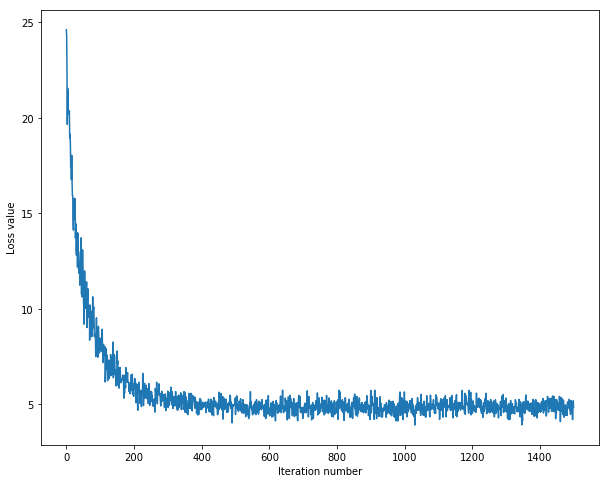

In [14]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [15]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print 'training accuracy: %f' % (np.mean(y_train == y_train_pred), )
y_val_pred = svm.predict(X_val)
print 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), )

training accuracy: 0.367367
validation accuracy: 0.370000


lr: 1e-10 reg: 0
iteration 0 / 1500: loss 24.946817
iteration 100 / 1500: loss 24.359012
iteration 200 / 1500: loss 25.391413
iteration 300 / 1500: loss 26.378606
iteration 400 / 1500: loss 21.515535
iteration 500 / 1500: loss 23.253422
iteration 600 / 1500: loss 23.587318
iteration 700 / 1500: loss 24.006957
iteration 800 / 1500: loss 25.612581
iteration 900 / 1500: loss 24.548867
iteration 1000 / 1500: loss 26.654140
iteration 1100 / 1500: loss 24.785570
iteration 1200 / 1500: loss 24.108239
iteration 1300 / 1500: loss 23.234382
iteration 1400 / 1500: loss 21.889460


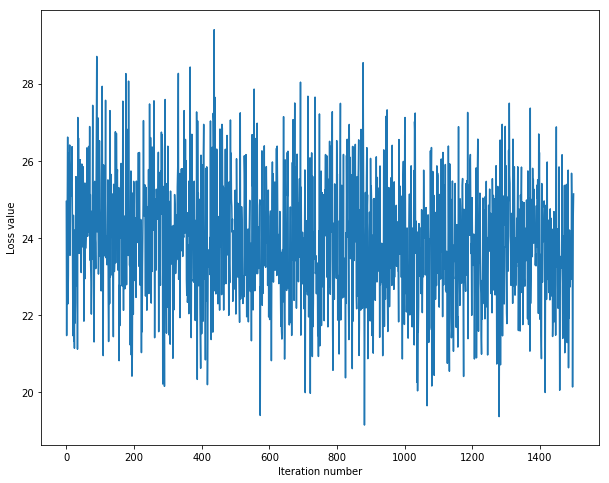

tr_acc: 0.0884081632653 val_acc: 0.089
lr: 1e-10 reg: 50000.0
iteration 0 / 1500: loss 19.660984
iteration 100 / 1500: loss 21.739258
iteration 200 / 1500: loss 22.128436
iteration 300 / 1500: loss 22.106464
iteration 400 / 1500: loss 22.400343
iteration 500 / 1500: loss 22.499841
iteration 600 / 1500: loss 20.385079
iteration 700 / 1500: loss 22.200188
iteration 800 / 1500: loss 22.651784
iteration 900 / 1500: loss 20.040539
iteration 1000 / 1500: loss 21.876211
iteration 1100 / 1500: loss 19.206041
iteration 1200 / 1500: loss 19.153743
iteration 1300 / 1500: loss 21.782536
iteration 1400 / 1500: loss 21.825725


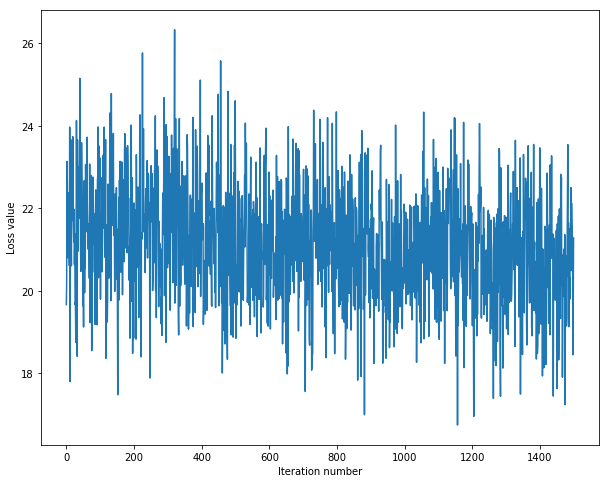

tr_acc: 0.0972857142857 val_acc: 0.091
lr: 1e-10 reg: 100000.0
iteration 0 / 1500: loss 24.380572
iteration 100 / 1500: loss 29.326781
iteration 200 / 1500: loss 27.215539
iteration 300 / 1500: loss 26.983970
iteration 400 / 1500: loss 30.309716
iteration 500 / 1500: loss 25.020702
iteration 600 / 1500: loss 26.026235
iteration 700 / 1500: loss 28.006768
iteration 800 / 1500: loss 24.486079
iteration 900 / 1500: loss 26.985859
iteration 1000 / 1500: loss 25.640216
iteration 1100 / 1500: loss 26.010227
iteration 1200 / 1500: loss 23.025101
iteration 1300 / 1500: loss 24.967152
iteration 1400 / 1500: loss 24.086609


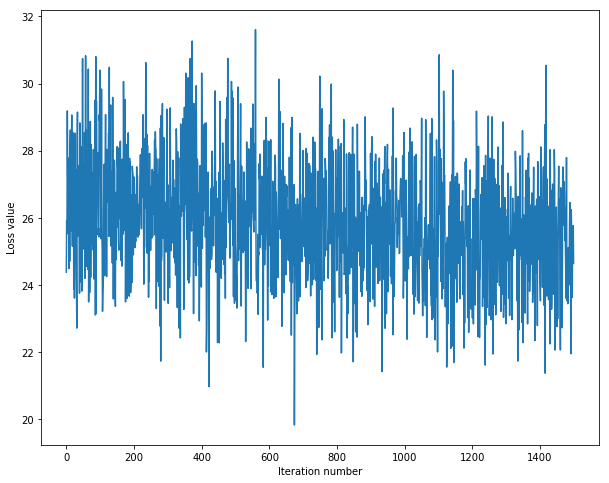

tr_acc: 0.0801836734694 val_acc: 0.096
lr: 1e-10 reg: 10000000000.0
iteration 0 / 1500: loss 23.274677
iteration 100 / 1500: loss 8.999126
iteration 200 / 1500: loss 8.999016
iteration 300 / 1500: loss 8.999020
iteration 400 / 1500: loss 8.998926
iteration 500 / 1500: loss 8.999224
iteration 600 / 1500: loss 8.998820
iteration 700 / 1500: loss 8.999185
iteration 800 / 1500: loss 8.999347
iteration 900 / 1500: loss 8.999265
iteration 1000 / 1500: loss 8.998994
iteration 1100 / 1500: loss 8.998955
iteration 1200 / 1500: loss 8.999340
iteration 1300 / 1500: loss 8.999047
iteration 1400 / 1500: loss 8.999226


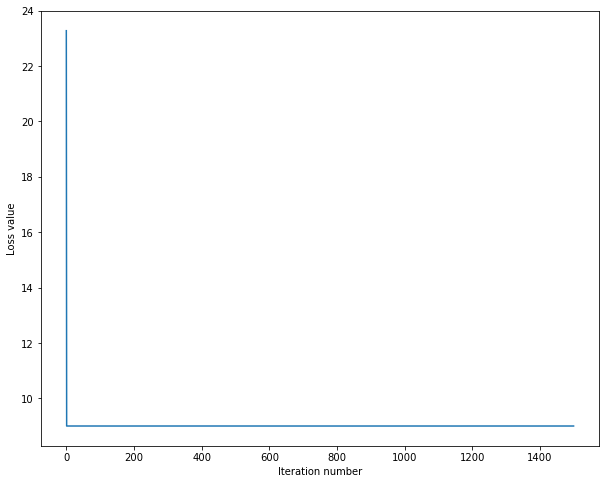

tr_acc: 0.225510204082 val_acc: 0.208
lr: 1e-08 reg: 0
iteration 0 / 1500: loss 26.448992
iteration 100 / 1500: loss 17.288126
iteration 200 / 1500: loss 15.747480
iteration 300 / 1500: loss 12.916381
iteration 400 / 1500: loss 12.482628
iteration 500 / 1500: loss 13.070536
iteration 600 / 1500: loss 12.003870
iteration 700 / 1500: loss 9.941673
iteration 800 / 1500: loss 10.181077
iteration 900 / 1500: loss 11.861211
iteration 1000 / 1500: loss 12.305904
iteration 1100 / 1500: loss 11.004863
iteration 1200 / 1500: loss 10.310568
iteration 1300 / 1500: loss 10.189209
iteration 1400 / 1500: loss 9.759882


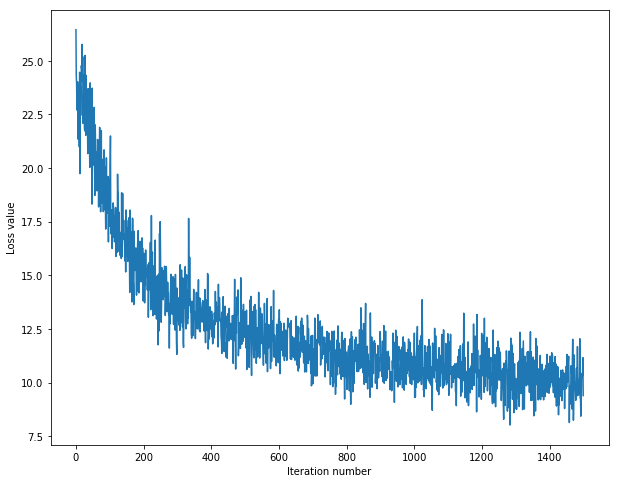

tr_acc: 0.220224489796 val_acc: 0.242
lr: 1e-08 reg: 50000.0
iteration 0 / 1500: loss 20.406607
iteration 100 / 1500: loss 18.707528
iteration 200 / 1500: loss 14.190295
iteration 300 / 1500: loss 11.982780
iteration 400 / 1500: loss 11.572069
iteration 500 / 1500: loss 10.187728
iteration 600 / 1500: loss 10.068368
iteration 700 / 1500: loss 9.162395
iteration 800 / 1500: loss 8.881637
iteration 900 / 1500: loss 7.960598
iteration 1000 / 1500: loss 7.397585
iteration 1100 / 1500: loss 6.756471
iteration 1200 / 1500: loss 6.631083
iteration 1300 / 1500: loss 7.540450
iteration 1400 / 1500: loss 7.148423


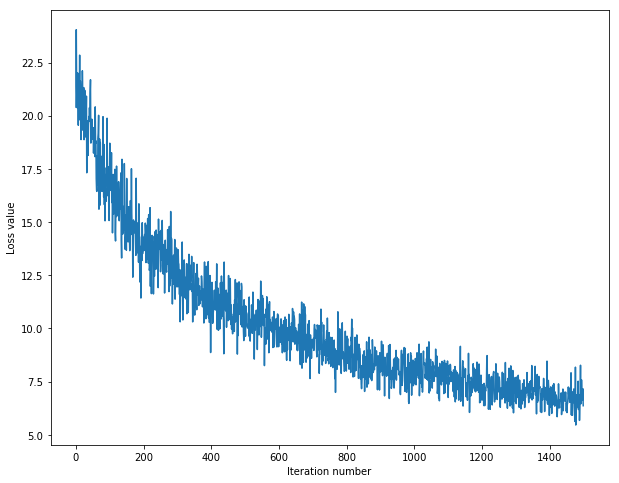

tr_acc: 0.254551020408 val_acc: 0.267
lr: 1e-08 reg: 100000.0
iteration 0 / 1500: loss 24.474315
iteration 100 / 1500: loss 16.521794
iteration 200 / 1500: loss 14.005379
iteration 300 / 1500: loss 11.699958
iteration 400 / 1500: loss 9.938967
iteration 500 / 1500: loss 8.321577
iteration 600 / 1500: loss 8.676480
iteration 700 / 1500: loss 7.832097
iteration 800 / 1500: loss 7.426034
iteration 900 / 1500: loss 6.419522
iteration 1000 / 1500: loss 6.519469
iteration 1100 / 1500: loss 6.236488
iteration 1200 / 1500: loss 5.523049
iteration 1300 / 1500: loss 5.435601
iteration 1400 / 1500: loss 5.752219


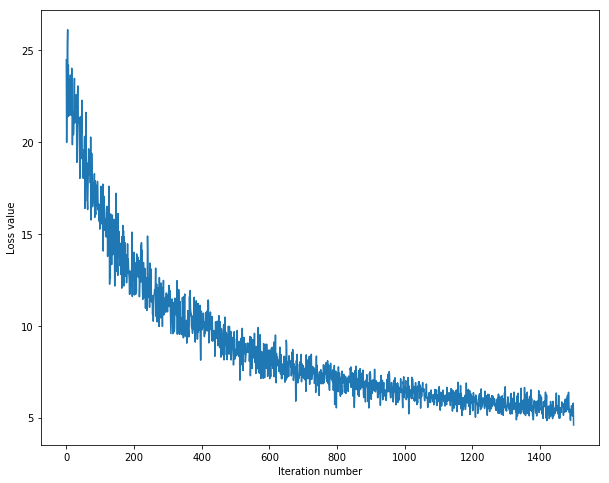

tr_acc: 0.307 val_acc: 0.321
lr: 1e-08 reg: 10000000000.0
iteration 0 / 1500: loss 28.896521
iteration 100 / 1500: loss 811039225189806265787682235123121681136612151318511043040235210206378858364209924111254356415217012064924870030422576180134789241838018026281228355017583236782830809272697916922749005625022698336813056.000000


cs231n/classifiers/linear_svm.py:111: RuntimeWarning: overflow encountered in multiply
  dW += reg * W
cs231n/classifiers/linear_svm.py:106: RuntimeWarning: invalid value encountered in less
  margins[margins < 0] = 0
cs231n/classifiers/linear_svm.py:107: RuntimeWarning: invalid value encountered in greater
  margins[margins > 0] = 1


iteration 200 / 1500: loss nan
iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan


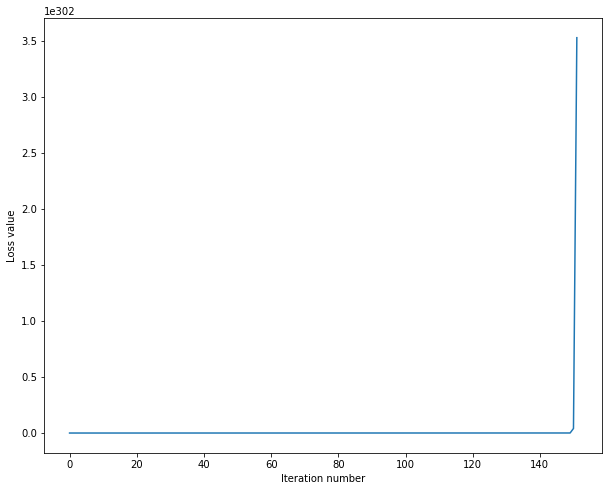

tr_acc: 0.100265306122 val_acc: 0.087
lr: 1e-07 reg: 0
iteration 0 / 1500: loss 26.348900
iteration 100 / 1500: loss 11.035037
iteration 200 / 1500: loss 9.626592
iteration 300 / 1500: loss 8.477660
iteration 400 / 1500: loss 7.776972
iteration 500 / 1500: loss 6.901570
iteration 600 / 1500: loss 7.496190
iteration 700 / 1500: loss 7.063567
iteration 800 / 1500: loss 6.445350
iteration 900 / 1500: loss 6.910954
iteration 1000 / 1500: loss 6.544907
iteration 1100 / 1500: loss 6.660335
iteration 1200 / 1500: loss 7.143654
iteration 1300 / 1500: loss 6.935357
iteration 1400 / 1500: loss 5.382588


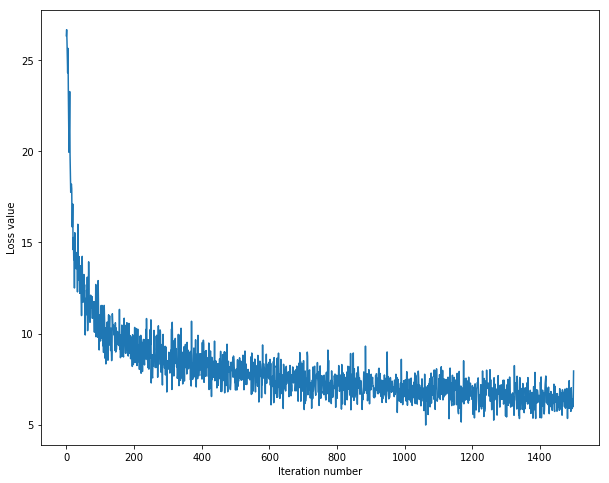

tr_acc: 0.305551020408 val_acc: 0.29
lr: 1e-07 reg: 50000.0
iteration 0 / 1500: loss 26.562656
iteration 100 / 1500: loss 8.602555
iteration 200 / 1500: loss 6.586461
iteration 300 / 1500: loss 5.379700
iteration 400 / 1500: loss 4.737344
iteration 500 / 1500: loss 4.533897
iteration 600 / 1500: loss 4.584996
iteration 700 / 1500: loss 4.852850
iteration 800 / 1500: loss 4.621137
iteration 900 / 1500: loss 4.473635
iteration 1000 / 1500: loss 5.567734
iteration 1100 / 1500: loss 4.594317
iteration 1200 / 1500: loss 4.671802
iteration 1300 / 1500: loss 4.808021
iteration 1400 / 1500: loss 5.362536


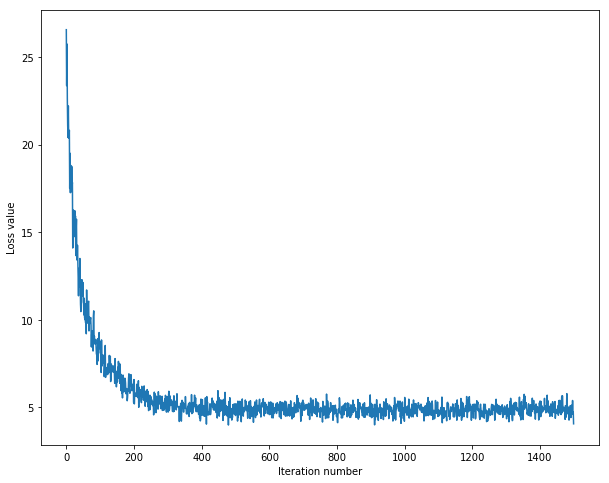

tr_acc: 0.371653061224 val_acc: 0.382
lr: 1e-07 reg: 100000.0
iteration 0 / 1500: loss 20.515046
iteration 100 / 1500: loss 6.630652
iteration 200 / 1500: loss 5.496759
iteration 300 / 1500: loss 4.975445
iteration 400 / 1500: loss 4.891634
iteration 500 / 1500: loss 4.700344
iteration 600 / 1500: loss 5.095535
iteration 700 / 1500: loss 4.740290
iteration 800 / 1500: loss 5.256511
iteration 900 / 1500: loss 4.697260
iteration 1000 / 1500: loss 4.836844
iteration 1100 / 1500: loss 4.809469
iteration 1200 / 1500: loss 5.233160
iteration 1300 / 1500: loss 5.184022
iteration 1400 / 1500: loss 5.152978


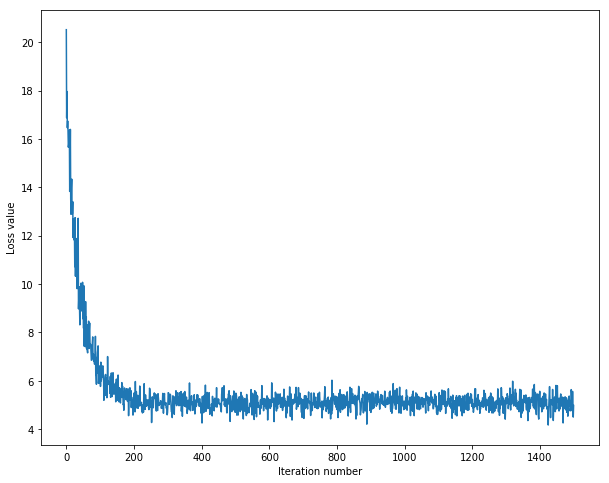

tr_acc: 0.365795918367 val_acc: 0.362
lr: 1e-07 reg: 10000000000.0
iteration 0 / 1500: loss 22.441572
iteration 100 / 1500: loss 15166658417553638221456801167591182100115988527341323627407360194164269700823985186427916429244957376588944885583795331108713974342327157858823826268778624845520665388852095212236178876479263728696708464589068593499461460789804400565008119640614313614521221119941249454665823101428230662581017578045440.000000
iteration 200 / 1500: loss nan
iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan


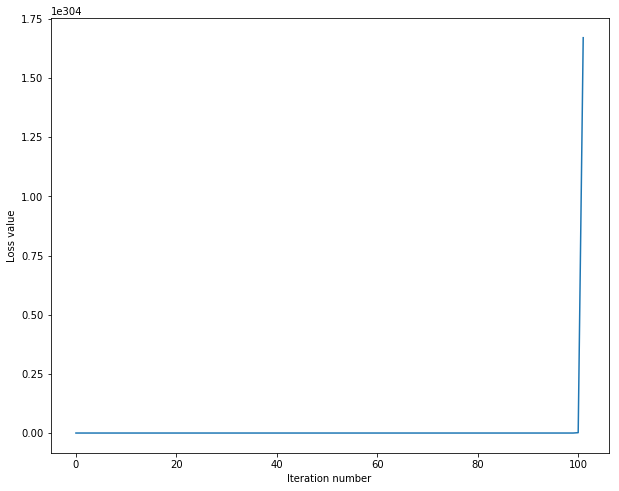

tr_acc: 0.100265306122 val_acc: 0.087
lr: 1e-05 reg: 0
iteration 0 / 1500: loss 20.046840
iteration 100 / 1500: loss 18.701775
iteration 200 / 1500: loss 30.138294
iteration 300 / 1500: loss 24.783780
iteration 400 / 1500: loss 18.926010
iteration 500 / 1500: loss 18.371626
iteration 600 / 1500: loss 18.889676
iteration 700 / 1500: loss 19.462708
iteration 800 / 1500: loss 16.024636
iteration 900 / 1500: loss 18.174713
iteration 1000 / 1500: loss 13.125851
iteration 1100 / 1500: loss 24.466274
iteration 1200 / 1500: loss 21.165419
iteration 1300 / 1500: loss 24.599906
iteration 1400 / 1500: loss 17.809458


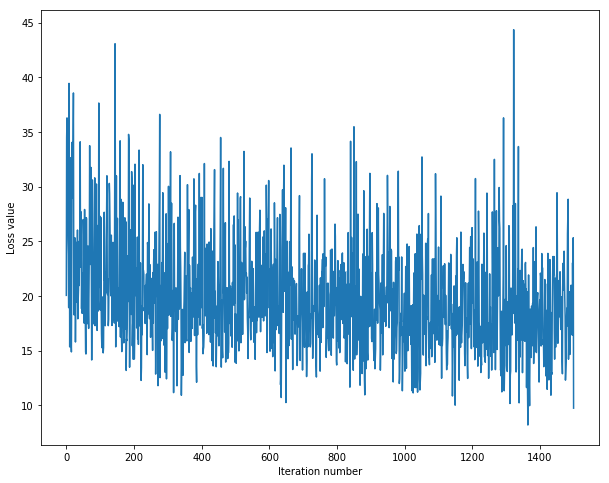

tr_acc: 0.342755102041 val_acc: 0.33
lr: 1e-05 reg: 50000.0
iteration 0 / 1500: loss 20.263879
iteration 100 / 1500: loss 30.031641
iteration 200 / 1500: loss 65.391085
iteration 300 / 1500: loss 44.560063
iteration 400 / 1500: loss 43.640111
iteration 500 / 1500: loss 60.507991
iteration 600 / 1500: loss 30.553629
iteration 700 / 1500: loss 52.142189
iteration 800 / 1500: loss 64.771715
iteration 900 / 1500: loss 32.779992
iteration 1000 / 1500: loss 49.172855
iteration 1100 / 1500: loss 54.113601
iteration 1200 / 1500: loss 48.006967
iteration 1300 / 1500: loss 54.147865
iteration 1400 / 1500: loss 48.240476


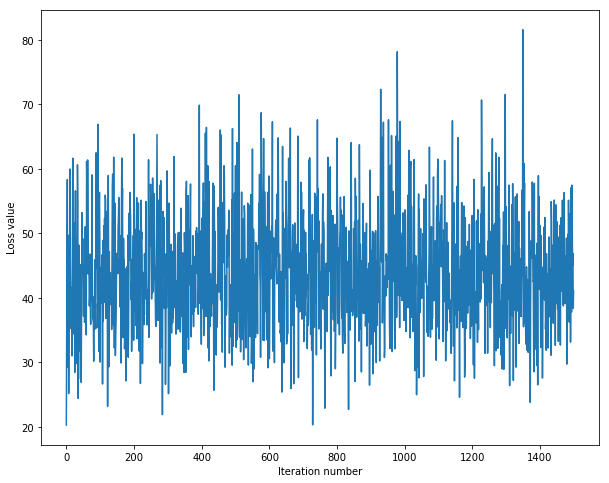

tr_acc: 0.209897959184 val_acc: 0.218
lr: 1e-05 reg: 100000.0
iteration 0 / 1500: loss 25.691723
iteration 100 / 1500: loss 76.278418
iteration 200 / 1500: loss 87.450113
iteration 300 / 1500: loss 56.959816
iteration 400 / 1500: loss 61.802414
iteration 500 / 1500: loss 74.823518
iteration 600 / 1500: loss 62.940437
iteration 700 / 1500: loss 86.264370
iteration 800 / 1500: loss 62.154975
iteration 900 / 1500: loss 71.003269
iteration 1000 / 1500: loss 64.639893
iteration 1100 / 1500: loss 77.727625
iteration 1200 / 1500: loss 86.703008
iteration 1300 / 1500: loss 70.508186
iteration 1400 / 1500: loss 67.696442


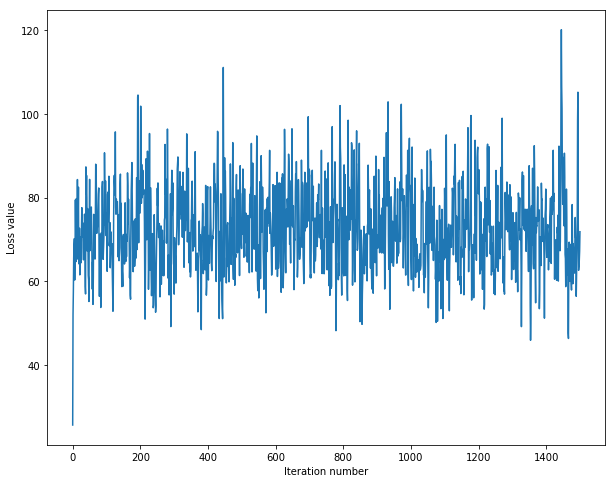

tr_acc: 0.200897959184 val_acc: 0.198
lr: 1e-05 reg: 10000000000.0
iteration 0 / 1500: loss 23.018441
iteration 100 / 1500: loss nan
iteration 200 / 1500: loss nan
iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan


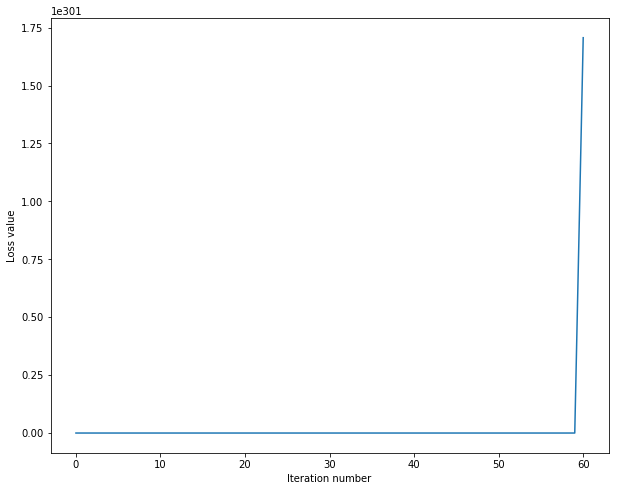

tr_acc: 0.100265306122 val_acc: 0.087
lr 1.000000e-10 reg 0.000000e+00 train accuracy: 0.088408 val accuracy: 0.089000
lr 1.000000e-10 reg 5.000000e+04 train accuracy: 0.097286 val accuracy: 0.091000
lr 1.000000e-10 reg 1.000000e+05 train accuracy: 0.080184 val accuracy: 0.096000
lr 1.000000e-10 reg 1.000000e+10 train accuracy: 0.225510 val accuracy: 0.208000
lr 1.000000e-08 reg 0.000000e+00 train accuracy: 0.220224 val accuracy: 0.242000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.254551 val accuracy: 0.267000
lr 1.000000e-08 reg 1.000000e+05 train accuracy: 0.307000 val accuracy: 0.321000
lr 1.000000e-08 reg 1.000000e+10 train accuracy: 0.100265 val accuracy: 0.087000
lr 1.000000e-07 reg 0.000000e+00 train accuracy: 0.305551 val accuracy: 0.290000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.371653 val accuracy: 0.382000
lr 1.000000e-07 reg 1.000000e+05 train accuracy: 0.365796 val accuracy: 0.362000
lr 1.000000e-07 reg 1.000000e+10 train accuracy: 0.100265 val accuracy:

In [16]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-10, 1e-8, 1e-7, 1e-5]
regularization_strengths = [0, 5e4, 1e5, 1e10]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
from cs231n.classifiers import LinearSVM
for lr in learning_rates:
    for reg in regularization_strengths:
        print "lr:", lr, "reg:", reg
        svm = LinearSVM()
        # first time set num_iters=200
        loss_hist = svm.train(X_train, y_train, lr, reg, num_iters=1500, verbose=True) 
        y_train_pred = svm.predict(X_train)
        train_acc = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val)
        val_acc = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (train_acc, val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_svm = svm
        plt.plot(loss_hist)
        plt.xlabel('Iteration number')
        plt.ylabel('Loss value')
        plt.show()
        print 'tr_acc:', train_acc, 'val_acc:', val_acc
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

(1e-08, 100000.0)
(1e-10, 0)
(1e-07, 100000.0)
(1e-05, 0)
(1e-07, 50000.0)
(1e-08, 0)
(1e-10, 10000000000.0)
(1e-05, 100000.0)
(1e-05, 50000.0)
(1e-10, 50000.0)
(1e-05, 10000000000.0)
(1e-07, 0)
(1e-07, 10000000000.0)
(1e-10, 100000.0)
(1e-08, 50000.0)
(1e-08, 10000000000.0)


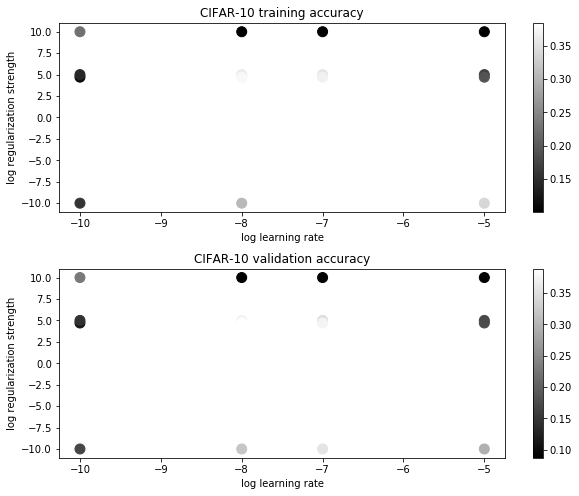

In [26]:
# Visualize the cross-validation results
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]+1e-10) for x in results]
for x in results:
    print x

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

plt.subplots_adjust(hspace = 0.3)

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [27]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'linear SVM on raw pixels final test set accuracy: %f' % test_accuracy

linear SVM on raw pixels final test set accuracy: 0.369000


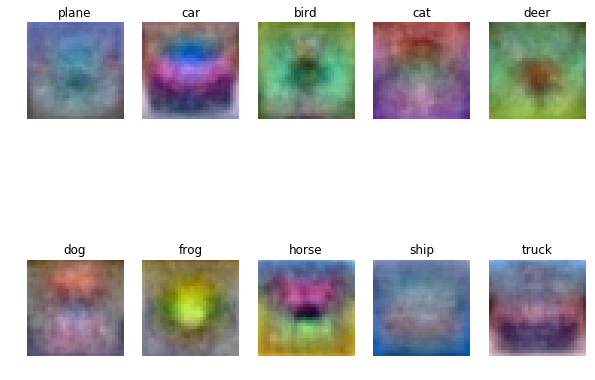

In [28]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*